In [159]:
# ===========================================
# 0. 設定（環境・パス・選手名）
# ===========================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# -------------------------------------------
# ターゲット選手を選ぶ（ここだけ変えればOK）
# -------------------------------------------
TARGET_PLAYER = "Kaoru YAMAWAKI"

# -------------------------------------------
# データパス設定（02/players 以下を使う）
# -------------------------------------------
BASE = f"/workspace/data/02/players/{TARGET_PLAYER}/"

STATIC_PATH  = BASE + f"{TARGET_PLAYER}_static.parquet"
DYNAMIC_PATH = BASE + f"{TARGET_PLAYER}_dynamic.parquet"
ACWR_PATH    = BASE + f"{TARGET_PLAYER}_acwr.parquet"   # 必須ではないが使える

print("TARGET PLAYER:", TARGET_PLAYER)
print("Static path :", STATIC_PATH)
print("Dynamic path:", DYNAMIC_PATH)

# -------------------------------------------
# データロード
# -------------------------------------------
df_static = pd.read_parquet(STATIC_PATH)
df_dyn    = pd.read_parquet(DYNAMIC_PATH)

df_static = df_static.sort_values("date_").reset_index(drop=True)
df_dyn    = df_dyn.sort_values("date_").reset_index(drop=True)

print("Loaded static :", df_static.shape)
print("Loaded dynamic:", df_dyn.shape)


TARGET PLAYER: Kaoru YAMAWAKI
Static path : /workspace/data/02/players/Kaoru YAMAWAKI/Kaoru YAMAWAKI_static.parquet
Dynamic path: /workspace/data/02/players/Kaoru YAMAWAKI/Kaoru YAMAWAKI_dynamic.parquet
Loaded static : (623, 54)
Loaded dynamic: (623, 12)


In [160]:
# ===========================================
# 1. 静的データ準備
# ===========================================

# GK 専用列（Field Player 分析のため除外）
gk_cols = [
    "total_dive_load_centre", "total_dive_load_left", "total_dive_load_right",
    "dive_right_count", "dive_left_count", "dive_centre_count",
    "total_dives_centre", "total_dives_left", "total_dives_right",
    "total_time_to_feet_centre", "total_time_to_feet_left", "total_time_to_feet_right"
]

# 除外しない基礎列
exclude_base = ["athlete_name", "date_"] + gk_cols

# 静的特徴量の候補
# 静的特徴量の候補（md_offset, md_phase は除外）
static_cols_fp = [
    c for c in df_static.columns
    if c not in ["athlete_name", "date_", "md_offset", "md_phase", "is_match_day"]
       and c not in gk_cols
]

# 作業用 DF
df_static_fp = df_static[ ["date_"] + static_cols_fp ].copy()

print("静的特徴量（FP用）:", len(static_cols_fp), "columns")

# --- 修正箇所ここから ---
# 標準偏差 0 の列を除外
# ⚠️ 修正: 文字列（md_phaseなど）が含まれているとエラーになるため、数値型のみを選択する処理を追加
X_raw = df_static_fp.drop(columns=["date_"]).select_dtypes(include=[np.number])

stds = X_raw.std()
non_zero_std_cols = stds[stds > 0].index.tolist()
# --- 修正箇所ここまで ---

print("標準偏差 > 0 の列数:", len(non_zero_std_cols))

# 最終的に使うデータ
X_static = X_raw[non_zero_std_cols].values

print("👉 静的データ準備完了")
print("X_static shape:", X_static.shape)


静的特徴量（FP用）: 37 columns
標準偏差 > 0 の列数: 36
👉 静的データ準備完了
X_static shape: (623, 36)


In [161]:
# ===========================================
# 2. 静的異常検知（Isolation Forest）
# ===========================================

# IsolationForest モデル
iso = IsolationForest(
    contamination=0.05,   # 異常日5%
    random_state=42
)

# 学習
iso_pred = iso.fit_predict(X_static)      # -1 = 異常
iso_score = iso.decision_function(X_static)  # スコア（低いほど異常）

# DataFrame に追加
df_static_fp["iso_score"] = iso_score
df_static_fp["iso_anomaly"] = (iso_pred == -1).astype(int)

print("異常日数:", df_static_fp["iso_anomaly"].sum())
print(df_static_fp.head())


異常日数: 32
       date_  session_duration_sec  total_duration  min_heart_rate  \
0 2023-01-12               8089.00         8089.00            88.0   
1 2023-01-13               4952.00         4952.00             0.0   
2 2023-01-14               6672.00         6672.00             0.0   
3 2023-01-16               6900.64         6900.64             0.0   
4 2023-01-17               5169.66         5169.66             0.0   

   velocity_band1_total_distance  velocity_band2_total_distance  \
0                     2586.79001                     3637.67002   
1                     2680.89000                     3394.86994   
2                     3486.83996                     4187.44994   
3                     3825.88004                     2508.10999   
4                     2269.78005                     3161.34000   

   velocity_band3_total_distance  gen2_velocity_band1_total_effort_count  \
0                      292.55000                                     0.0   
1              

In [162]:
# ===========================================
# 2.5 異常日のトップ特徴量（理由）の抽出関数
# ===========================================

# 標準化のための統計量
mean_vec = X_raw[non_zero_std_cols].mean()
std_vec  = X_raw[non_zero_std_cols].std()

def top_contributing_features(row, n=5):
    """
    1日の特徴量 row を受け取り、
    Z-score の絶対値が大きい上位 n 個を返す。
    """
    values = row[non_zero_std_cols]
    z = (values - mean_vec) / std_vec
    z_abs = z.abs()

    return z_abs.sort_values(ascending=False).head(n)


# 異常日の理由をリスト化する
anomaly_days = df_static_fp[df_static_fp["iso_anomaly"] == 1].copy()
anomaly_days["top_features"] = anomaly_days.apply(
    lambda row: top_contributing_features(row, n=5).index.tolist(),
    axis=1
)

print("異常日サンプル:")
display(anomaly_days[["date_", "top_features"]].head())


異常日サンプル:


,date_,top_features
8,2023-01-22,"[ima_band2_decel_count, ima_band3_decel_count,..."
13,2023-01-27,"[velocity2_band6_total_distance, velocity2_ban..."
16,2023-02-01,"[metabolic_power_band3_total_distance, gen2_ve..."
17,2023-02-02,"[velocity_band3_total_distance, metabolic_powe..."
21,2023-02-12,"[velocity2_band6_total_distance, velocity2_ban..."


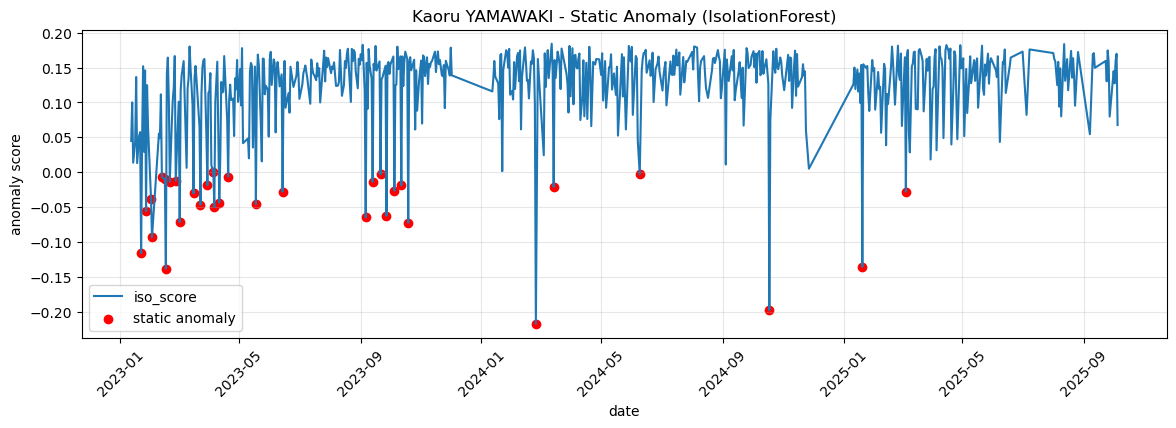

In [163]:
# ===========================================
# 2.6 静的異常スコアのミニ可視化（1枚だけ）
# ===========================================
plt.figure(figsize=(14,4))
plt.plot(df_static_fp["date_"], df_static_fp["iso_score"], label="iso_score")

# 異常日を赤く表示
anom_mask = df_static_fp["iso_anomaly"] == 1
plt.scatter(
    df_static_fp["date_"][anom_mask],
    df_static_fp["iso_score"][anom_mask],
    color="red",
    label="static anomaly"
)

plt.title(f"{TARGET_PLAYER} - Static Anomaly (IsolationForest)")
plt.xlabel("date")
plt.ylabel("anomaly score")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [164]:
# ===========================================
# ★ 2.7 静的ラベルの保存
# ===========================================

save_static = df_static_fp[["date_", "iso_score", "iso_anomaly"]].copy()

# top_features（異常日のみ）
save_static = save_static.merge(
    anomaly_days[["date_", "top_features"]],
    on="date_",
    how="left"
)

SAVE_DIR = f"/workspace/data/03/players/{TARGET_PLAYER}"
os.makedirs(SAVE_DIR, exist_ok=True)

STATIC_LABEL_PATH = f"{SAVE_DIR}/static_labels.parquet"
save_static.to_parquet(STATIC_LABEL_PATH, index=False)

print("💾 Saved static labels →", STATIC_LABEL_PATH)


💾 Saved static labels → /workspace/data/03/players/Kaoru YAMAWAKI/static_labels.parquet


In [165]:
# ===========================================
# 3. 動的データ準備
# ===========================================

# 既にロード済み（df_dyn）
print("🔍 動的データ shape:", df_dyn.shape)

# 日付確認
df_dyn = df_dyn.sort_values("date_").reset_index(drop=True)

print("🔍 動的最初の5行:")
display(df_dyn.head())


🔍 動的データ shape: (623, 12)
🔍 動的最初の5行:


,athlete_name,date_,md_offset,md_phase,is_match_day,max_vel,mean_heart_rate,max_heart_rate,velocity_band4_total_distance,velocity_band5_total_distance,velocity_band6_total_distance,heart_rate_band3_total_duration
0,Kaoru YAMAWAKI,2023-01-12,-13,OTHER,0,28.49351,155.842712,195.0,291.52,494.92999,295.72001,2171.00004
1,Kaoru YAMAWAKI,2023-01-13,-12,OTHER,0,30.56668,158.254888,189.0,130.90,79.77000,238.53000,1741.00000
2,Kaoru YAMAWAKI,2023-01-14,-11,OTHER,0,31.08442,142.445105,192.0,289.56,99.93000,143.83000,2342.79998
3,Kaoru YAMAWAKI,2023-01-16,-9,OTHER,0,27.34162,124.967800,184.0,1943.47,1210.29006,302.02999,1600.30001
4,Kaoru YAMAWAKI,2023-01-17,-8,OTHER,0,26.67819,82.781118,138.0,323.88,169.95000,61.56000,127.40000


In [166]:
# %% 
# 動的特徴量の列（athlete_name / 日付 / MD文脈列を除く）
dynamic_feature_cols = [
    c for c in df_dyn.columns 
    if c not in ["athlete_name", "date_", "md_phase", "md_offset", "is_match_day"]
]

X_dyn_raw = df_dyn[dynamic_feature_cols].astype(float).values
dates_dyn = df_dyn["date_"].values

print("動的特徴量数:", len(dynamic_feature_cols))
print("X_dyn_raw shape:", X_dyn_raw.shape)


動的特徴量数: 7
X_dyn_raw shape: (623, 7)


In [167]:
# ===========================================
# 3.3 スケーリング
# ===========================================
scaler_dyn = StandardScaler()
X_dyn_scaled = scaler_dyn.fit_transform(X_dyn_raw)

print("スケーリング後 shape:", X_dyn_scaled.shape)


スケーリング後 shape: (623, 7)


In [168]:
# ===========================================
# 3.4 シーケンス化（シーズン跨ぎを滑らかに接続）
# ===========================================

SEQ_LEN = 30
BREAK_DAYS = 30

# 日付差からシーズンブロックを定義
gap_days = df_dyn["date_"].diff().dt.days
season_block = (gap_days > BREAK_DAYS).cumsum().fillna(0).astype(int)
df_dyn["season_block"] = season_block

seq_list = []
seq_dates = []           # ← 本来の「正しい日付」を保持

for block_id in sorted(df_dyn["season_block"].unique()):

    # ============================
    # ■ このブロックのデータ
    # ============================
    mask = df_dyn["season_block"] == block_id
    X_block = X_dyn_scaled[mask]
    dates_block = dates_dyn[mask]

    if len(X_block) == 0:
        continue

    # ============================
    # ■ 前のブロック末尾30日を付ける
    # ============================
    if block_id > 0:

        prev_mask = df_dyn["season_block"] == (block_id - 1)
        X_prev = X_dyn_scaled[prev_mask]
        dates_prev = dates_dyn[prev_mask]

        if len(X_prev) > 0:
            tail_len = min(SEQ_LEN, len(X_prev))
            X_tail = X_prev[-tail_len:]
            dates_tail = dates_prev[-tail_len:]
        else:
            X_tail = np.empty((0, X_dyn_scaled.shape[1]))
            dates_tail = np.empty((0,), dtype=object)
    else:
        # block_id==0 → 前シーズン無し
        X_tail = np.empty((0, X_dyn_scaled.shape[1]))
        dates_tail = np.empty((0,), dtype=object)

    # ============================
    # ■ 前シーズン末尾 + 今シーズンのブロックを接続
    # ============================
    X_ext = np.vstack([X_tail, X_block])
    dates_ext = np.concatenate([dates_tail, dates_block])

    # ============================
    # ■ シーケンス化（本来の block 部分だけ判定対象）
    # ============================
    start_idx = len(X_tail)  # 元の season_block が始まる位置

    for i in range(start_idx, len(X_ext)):
        if i - SEQ_LEN + 1 < 0:
            continue

        seq = X_ext[i-SEQ_LEN+1:i+1]
        seq_list.append(seq)

        # このシーケンスの「本来の日付」
        seq_dates.append(dates_ext[i])

# 最終的な numpy 配列
seq_array = np.stack(seq_list)

print("シーケンス数:", len(seq_array))
print("shape:", seq_array.shape)




シーケンス数: 594
shape: (594, 30, 7)


In [169]:
# ===========================================
# 3.5 PyTorch Dataset & DataLoader
# ===========================================

class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x = self.sequences[idx]
        return torch.tensor(x, dtype=torch.float32)

dataset = SequenceDataset(seq_array)

# train : val = 7 : 3（時系列なので前半を train）
train_ratio = 0.7
train_size = int(len(dataset) * train_ratio)
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("train size:", len(train_dataset))
print("val   size:", len(val_dataset))


train size: 415
val   size: 179


In [170]:
# ===========================================
# 4. LSTM AutoEncoder モデル定義（安定版）
# ===========================================

class LSTMAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32, num_layers=2, dropout=0.1):
        super().__init__()

        # ----- Encoder -----
        self.encoder_lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.encoder_fc = nn.Linear(hidden_dim, latent_dim)

        # ----- Decoder -----
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(
            hidden_dim,
            input_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        enc_out, _ = self.encoder_lstm(x)
        h_last = enc_out[:, -1, :]                  # 最終ステップの隠れ状態
        z = self.encoder_fc(h_last)                 # latent vector

        # latent → decoder 初期値
        dec_init = self.decoder_fc(z).unsqueeze(1) # (batch, 1, hidden_dim)
        dec_init = dec_init.repeat(1, x.size(1), 1) # (batch, seq_len, hidden_dim)

        dec_out, _ = self.decoder_lstm(dec_init)    # (batch, seq_len, input_dim)
        return dec_out


In [171]:
# ===========================================
# 4.1 モデル初期化
# ===========================================

input_dim = X_dyn_scaled.shape[1]  # 動的特徴量数

model = LSTMAutoEncoder(
    input_dim=input_dim,
    hidden_dim=64,
    latent_dim=32,
    num_layers=2,
    dropout=0.1
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("✅ Model ready on device:", device)


✅ Model ready on device: cpu


Epoch   1 | train: 0.966422 | val: 1.037165


Epoch   2 | train: 0.908870 | val: 0.963640
Epoch   3 | train: 0.849808 | val: 0.914036
Epoch   4 | train: 0.808494 | val: 0.879034
Epoch   5 | train: 0.781318 | val: 0.854719
Epoch   6 | train: 0.760186 | val: 0.835956
Epoch   7 | train: 0.743740 | val: 0.821459
Epoch   8 | train: 0.731329 | val: 0.810274
Epoch   9 | train: 0.720068 | val: 0.801735
Epoch  10 | train: 0.711031 | val: 0.790888
Epoch  11 | train: 0.702686 | val: 0.791523
Epoch  12 | train: 0.699693 | val: 0.781482
Epoch  13 | train: 0.692046 | val: 0.778500
Epoch  14 | train: 0.688104 | val: 0.776467
Epoch  15 | train: 0.685102 | val: 0.773109
Epoch  16 | train: 0.682979 | val: 0.770969
Epoch  17 | train: 0.681134 | val: 0.769347
Epoch  18 | train: 0.679135 | val: 0.766588
Epoch  19 | train: 0.676410 | val: 0.766316
Epoch  20 | train: 0.672783 | val: 0.765119
Epoch  21 | train: 0.669635 | val: 0.762828
Epoch  22 | train: 0.668151 | val: 0.762629
Epoch  23 | train: 0.667013 | val: 0.762909
Epoch  24 | train: 0.666955 | va

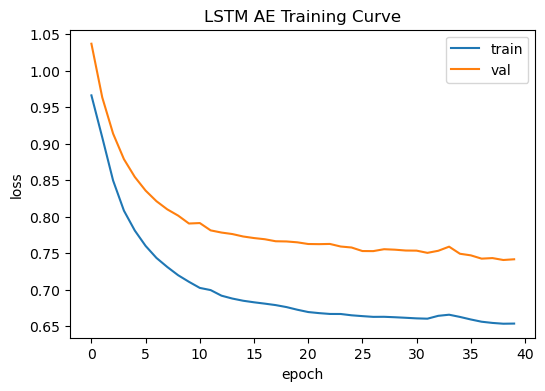

In [172]:
# ===========================================
# 4.2 学習ループ（安定）
# ===========================================

EPOCHS = 40

def evaluate(loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x in loader:
            x = x.to(device)
            recon = model(x)
            loss = criterion(recon, x)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_train = 0

    for x in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon = model(x)
        loss = criterion(recon, x)
        loss.backward()
        optimizer.step()
        total_train += loss.item() * x.size(0)

    train_loss = total_train / len(train_dataset)
    val_loss   = evaluate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:3d} | train: {train_loss:.6f} | val: {val_loss:.6f}")

# 学習曲線
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("LSTM AE Training Curve")
plt.show()


In [173]:
# ===========================================
# 5. 全シーケンスの再構成誤差の計算
# ===========================================

model.eval()

all_errors = []
with torch.no_grad():
    for i in range(len(seq_array)):
        x = torch.tensor(seq_array[i:i+1], dtype=torch.float32).to(device)
        recon = model(x)
        err = ((recon - x) ** 2).mean().item()
        all_errors.append(err)

all_errors = np.array(all_errors)

print("📌 Reconstruction error stats:")
print(" mean:", all_errors.mean())
print(" std :", all_errors.std())

📌 Reconstruction error stats:
 mean: 0.6783599259350637
 std : 1.0623027730357817


In [174]:
# ===========================================
# 5.1 season_reset_zone の導入（1回だけ）
# ===========================================

# seq_dates は「各シーケンスの最後の日付」
df_dyn_seq = pd.DataFrame({
    "date_": seq_dates,
    "dyn_error": all_errors,
})

# 🔥 dtype を揃える（これが最重要）
df_dyn_seq["date_"] = pd.to_datetime(df_dyn_seq["date_"])

df_dyn_block = df_dyn[["date_", "season_block"]].drop_duplicates().copy()
df_dyn_block["date_"] = pd.to_datetime(df_dyn_block["date_"])

# merge（これで DateTime mismatch が消える）
df_dyn_base = df_dyn_seq.merge(df_dyn_block, on="date_", how="left")

# ---------------------------
# reset zone を決める（1回だけ）
# ---------------------------
N_RESET_DAYS = 1   # ← Haruki さんが選んだ値

df_dyn_base["season_reset_zone"] = 0

for block_id, sub in df_dyn_block.groupby("season_block"):

    # ブロック0は最初のシーズンなので reset zone に含めない
    if block_id == 0:
        continue

    block_start = sub["date_"].min()
    reset_end = block_start + pd.Timedelta(days=N_RESET_DAYS - 1)

    mask = (
        (df_dyn_base["date_"] >= block_start) &
        (df_dyn_base["date_"] <= reset_end)
    )
    df_dyn_base.loc[mask, "season_reset_zone"] = 1


# ---------------------------
# reset zone を除外して閾値計算
# ---------------------------
valid_mask = df_dyn_base["season_reset_zone"] == 0
valid_errors = df_dyn_base.loc[valid_mask, "dyn_error"]

if len(valid_errors) > 0:
    threshold = valid_errors.mean() + 3 * valid_errors.std()
else:
    threshold = df_dyn_base["dyn_error"].mean() + 3 * df_dyn_base["dyn_error"].std()

print("🔥 Dynamic anomaly threshold (reset zone 除外):", threshold)

# ---------------------------
# 異常判定
# ---------------------------
df_dyn_base["dyn_anomaly"] = (
    (df_dyn_base["dyn_error"] > threshold) &
    (df_dyn_base["season_reset_zone"] == 0)   # reset zone は異常扱いにしない
).astype(int)

df_dyn_anom = df_dyn_base.copy()


🔥 Dynamic anomaly threshold (reset zone 除外): 3.815614294512481


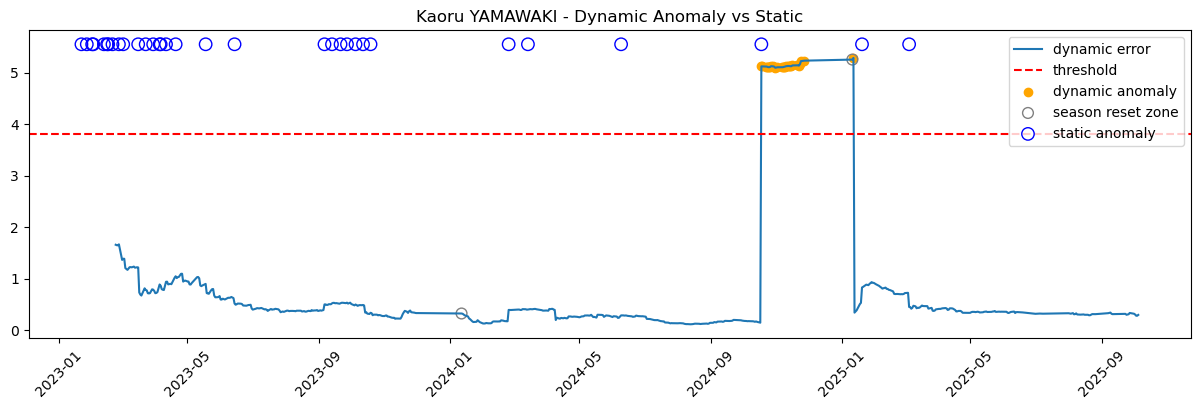

In [175]:

# %%
plt.figure(figsize=(15,4))
plt.plot(df_dyn_anom["date_"], df_dyn_anom["dyn_error"], label="dynamic error")
plt.axhline(threshold, color="red", linestyle="--", label="threshold")

# 動的異常
mask_dyn = df_dyn_anom["dyn_anomaly"] == 1
plt.scatter(
    df_dyn_anom["date_"][mask_dyn],
    df_dyn_anom["dyn_error"][mask_dyn],
    color="orange",
    label="dynamic anomaly"
)

# reset zone を可視化（任意）
reset_mask = df_dyn_anom["season_reset_zone"] == 1
if reset_mask.any():
    plt.scatter(
        df_dyn_anom["date_"][reset_mask],
        df_dyn_anom["dyn_error"][reset_mask],
        edgecolors="gray",
        facecolors="none",
        s=60,
        label="season reset zone"
    )

# 静的異常を重ねる（そのまま）
plt.scatter(
    df_static_fp["date_"][df_static_fp["iso_anomaly"] == 1],
    np.full(df_static_fp["iso_anomaly"].sum(), df_dyn_anom["dyn_error"].max() * 1.05),
    edgecolors="blue",
    facecolors='none',
    s=80,
    label="static anomaly"
)

plt.title(f"{TARGET_PLAYER} - Dynamic Anomaly vs Static")
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [176]:
# %%
SAVE_DIR_03 = f"/workspace/data/03/players/{TARGET_PLAYER}"
os.makedirs(SAVE_DIR_03, exist_ok=True)

OUTPUT_PATH = f"{SAVE_DIR_03}/dynamic_labels.parquet"
df_dyn_anom.to_parquet(OUTPUT_PATH, index=False)

print("💾 Saved dynamic labels →", OUTPUT_PATH)


💾 Saved dynamic labels → /workspace/data/03/players/Kaoru YAMAWAKI/dynamic_labels.parquet
